In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (12, 8)

import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [3]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [4]:
import numpy as np
from sklearn.cluster import KMeans

bcp_size = []
def bcp_brute(a, b):
    bcp_size.append(len(a) + len(b))
    min_dist = np.inf
    min_a = None
    min_b = None
    for ai in a:
        for bi in b:
            d = np.sqrt((ai[0] - bi[0])**2 + (ai[1] - bi[1])**2)
            if d < min_dist:
                min_dist = d
                min_a = ai
                min_b = bi
    return min_dist, min_a, min_b

def cluster(x, y):
    try:
        x = x.compressed()
        y = y.compressed()
    except AttributeError:
        pass
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    X = np.vstack((x, y)).transpose()
    
    kmeans = KMeans(2).fit(X)
    index0 = kmeans.labels_ == 0
    index1 = kmeans.labels_ == 1
    
    a = list(zip(x[index0], y[index0]))
    b = list(zip(x[index1], y[index1]))
    return a, b

## calculate forward point
# We make some simplifications in the bicycle geometry
# (namely ignoring changes in roll and pitch and yaw)
# as they will be small as we are near the nominal orientation.

# If we assume the front wheel is upright, the lidar will detect
# a point on the wheel at height 'h' from the ground.
# The projection of the vector from the front wheel center to
# the lidar detection point onto the ground is the distance 'b'.
# The vector to offset the lidar detection point is then 'r - b'
# at the specified steer angle.

lidar_height = 0.25 # m TODO: find this measurement
front_wheel_radius = 0.359 # m
    
def closest_pair(x, y):
    # get clusters
    a, b = cluster(x, y)
    
    # calculate minumum distance
    # TODO: account for wheel radius and LIDAR height
    # unlikely to make a difference in results?
    """
    In [36]: h = 0.25
    
    In [37]: r = 0.359
    
    In [38]: b = np.sqrt(r**2 - (r - h)**2)
    
    In [39]: r - b
    Out[39]: 0.016947372470258626
    """
    d, pair_a, pair_b = bcp_brute(a, b)
    return d, pair_a, pair_b, a, b

def plot_closest_pair(ax, pair_a, pair_b, set_a, set_b, color_offset=0):
    colors = sns.color_palette('Paired', 10)

    ax.plot(*zip(*set_a), '.', color=colors[color_offset + 0],
            label='t={:0.03f} s'.format(record.lidar.time[i]))
    ax.plot(*zip(*set_b), '.', color=colors[color_offset + 2],
            label='t={:0.03f} s'.format(record.lidar.time[i]))
    ax.plot(*pair_a, 'o', color=colors[color_offset + 1])
    ax.plot(*pair_b, 'o', color=colors[color_offset + 3])
    ax.plot(*zip(*np.vstack((pair_a, pair_b))), color=colors[5])

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


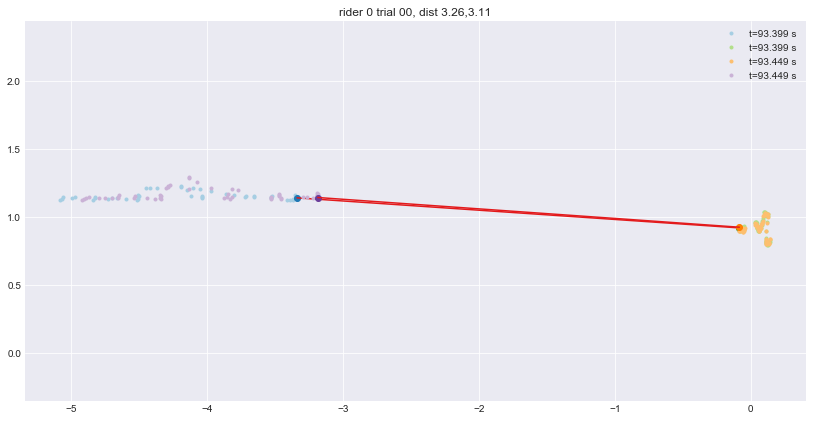

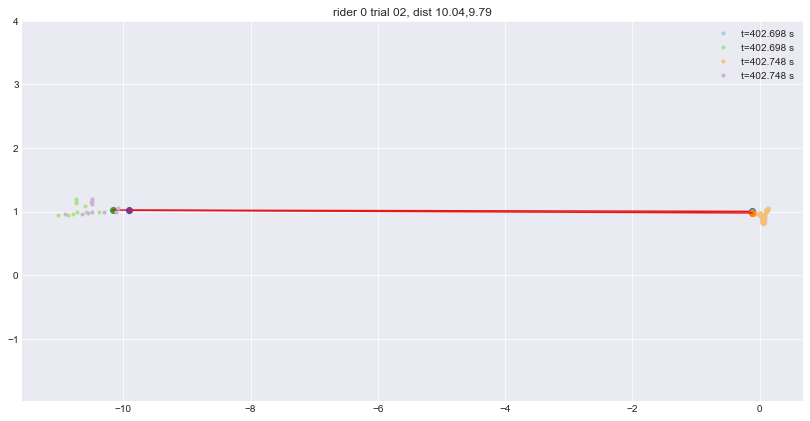

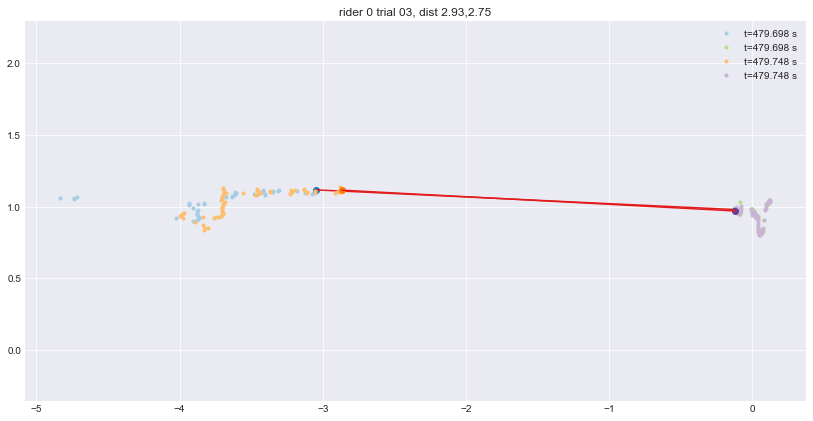

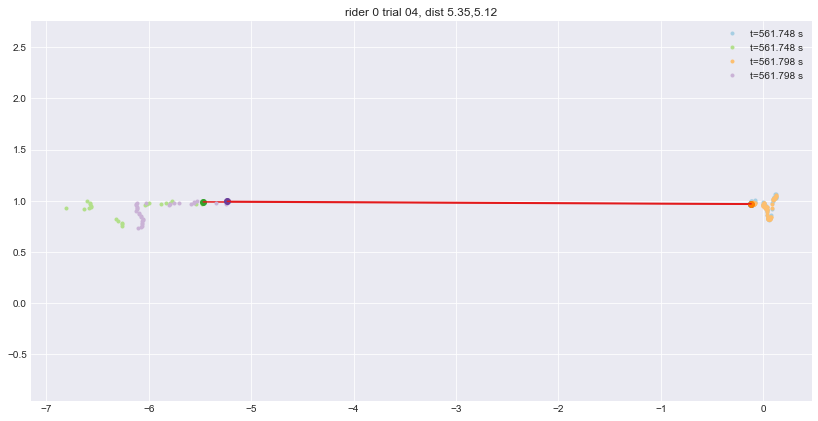

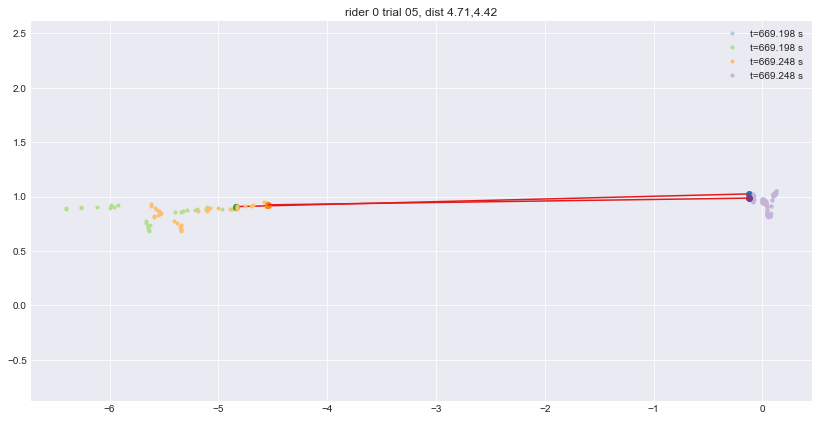

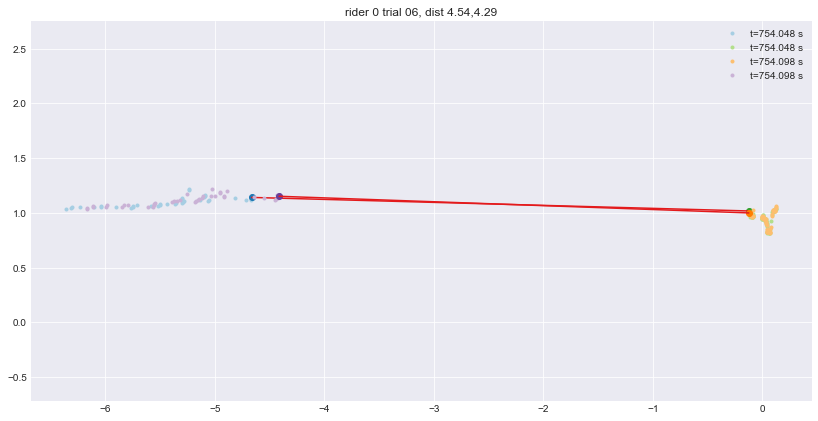

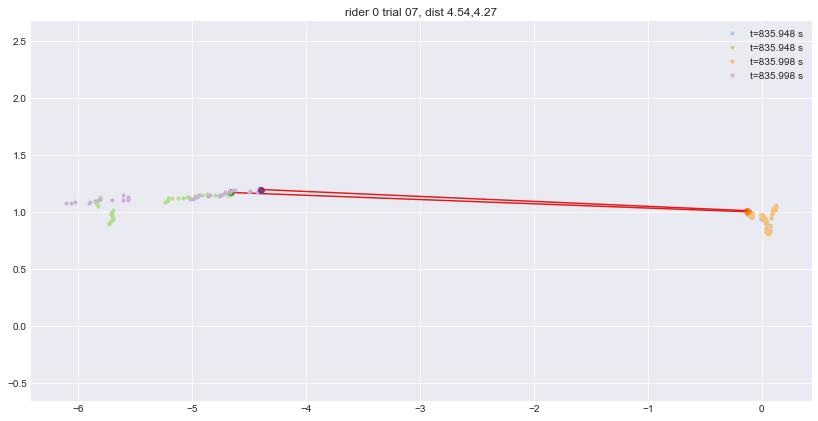

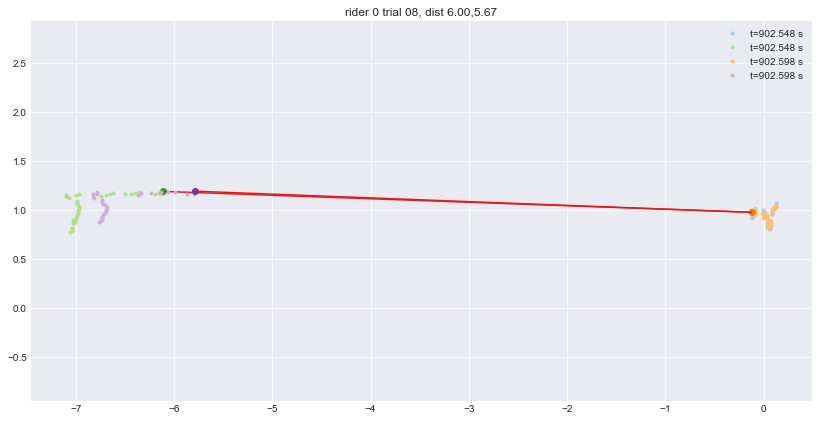

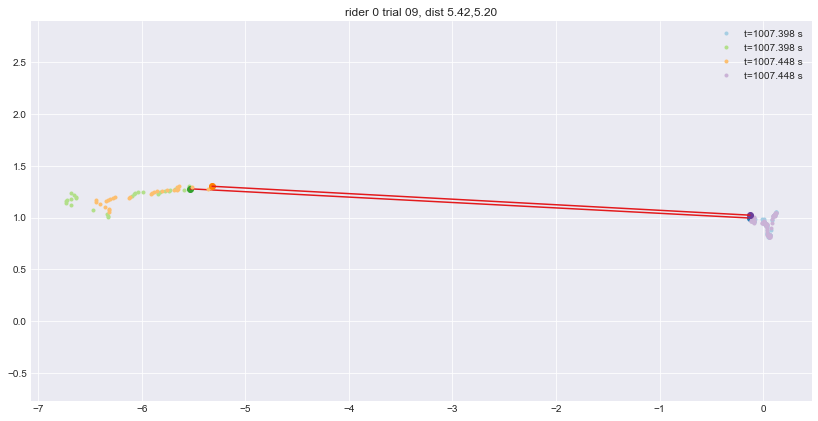

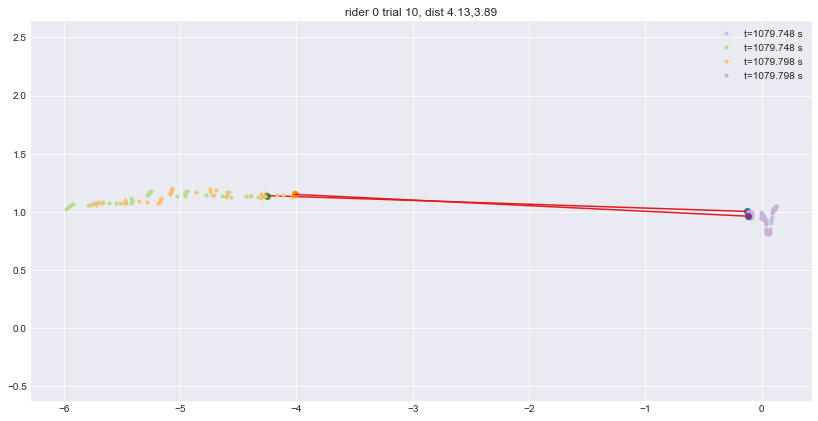

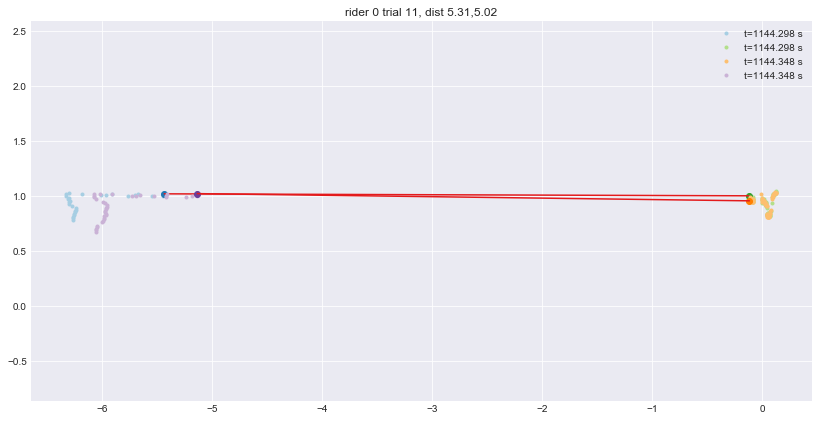

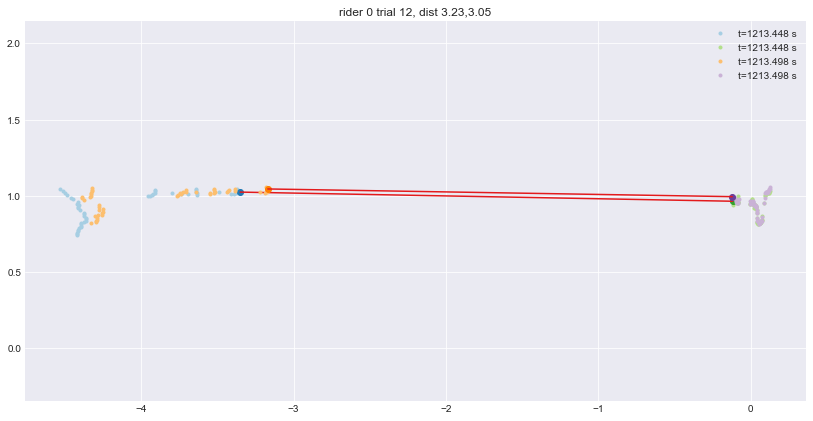

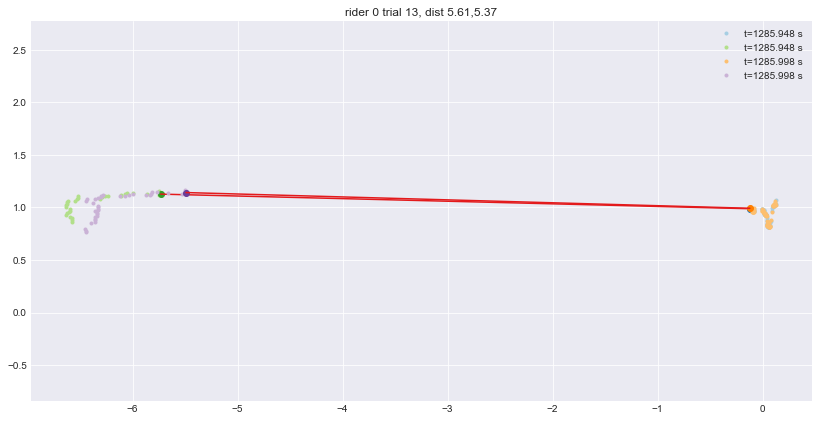

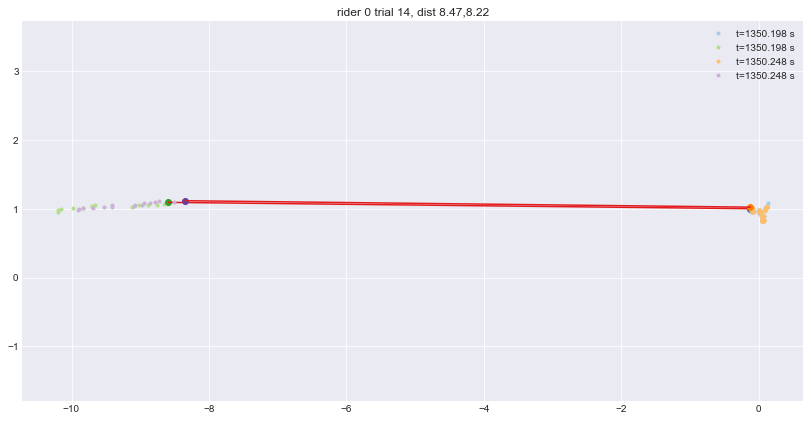

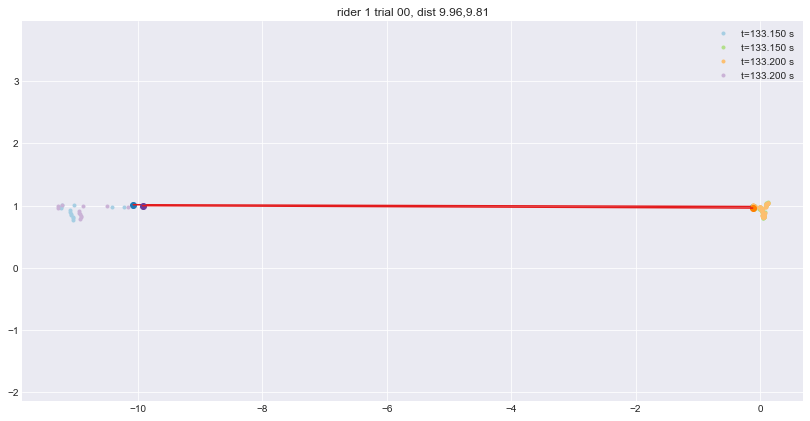

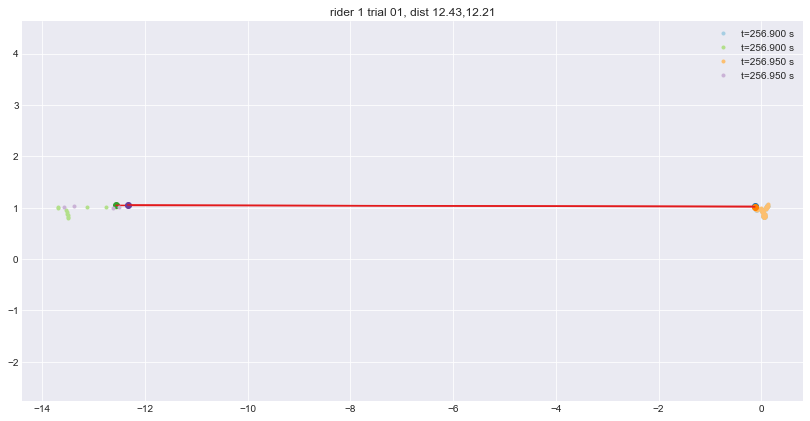

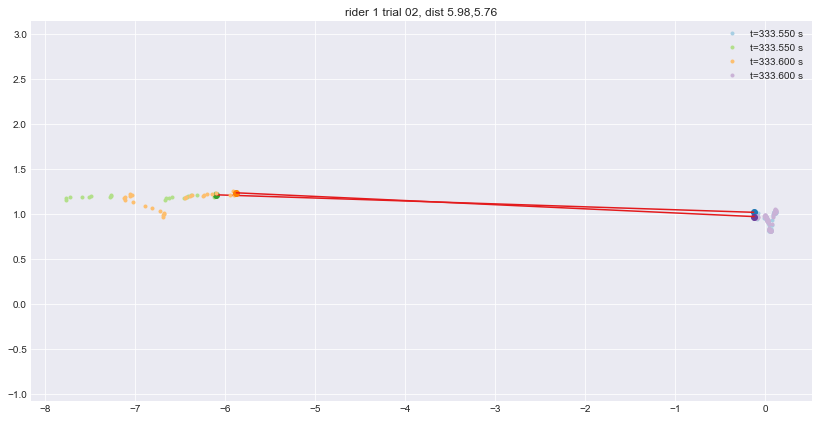

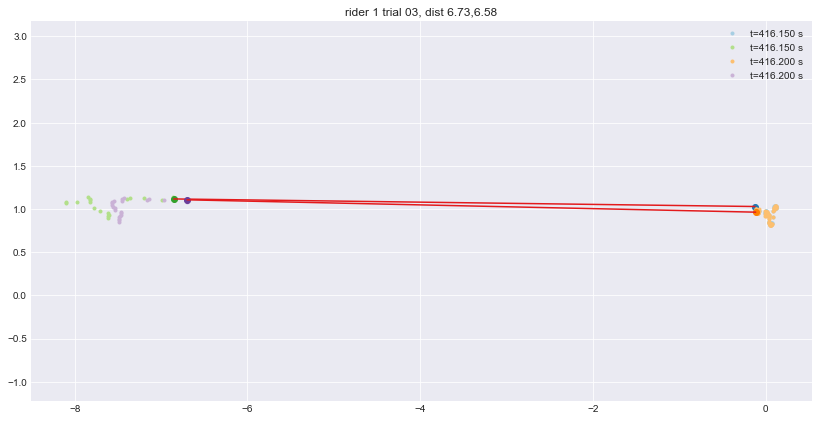

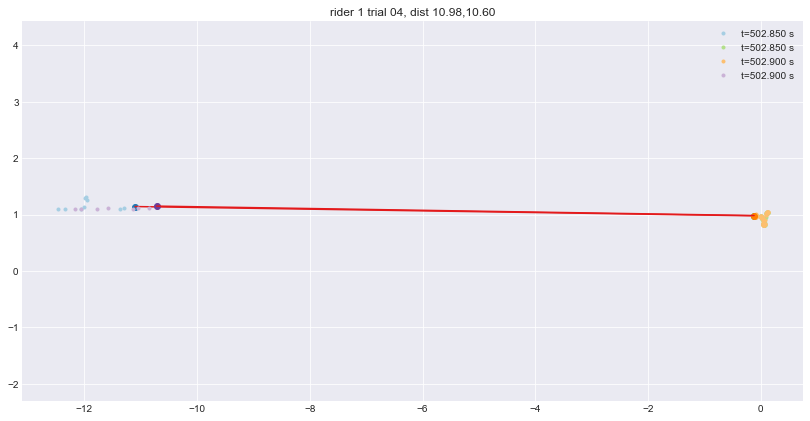

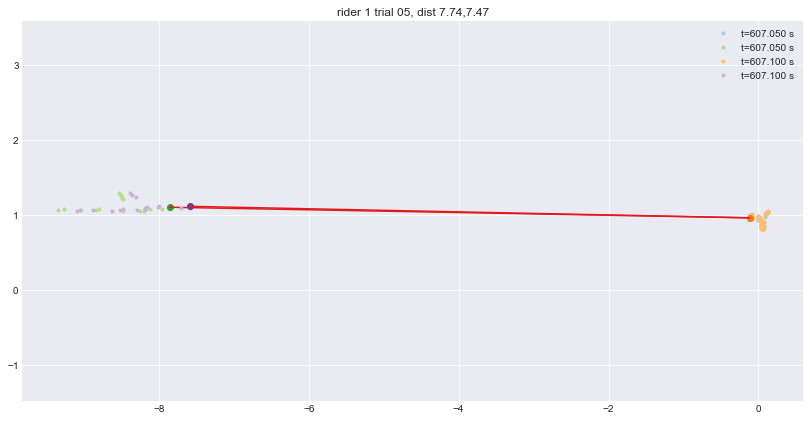

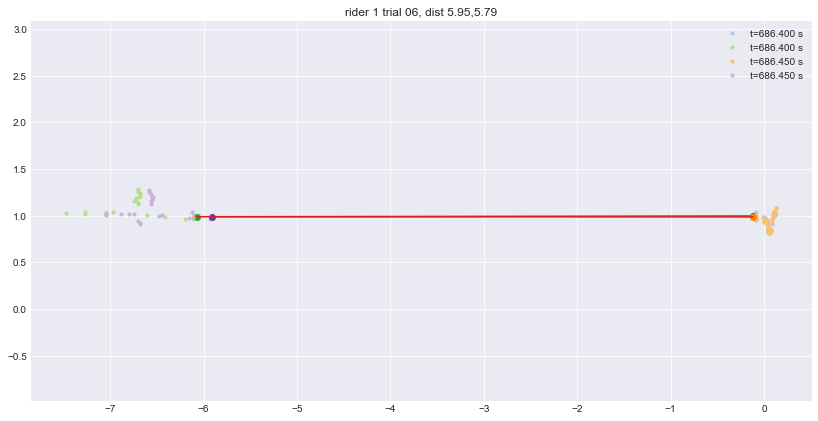

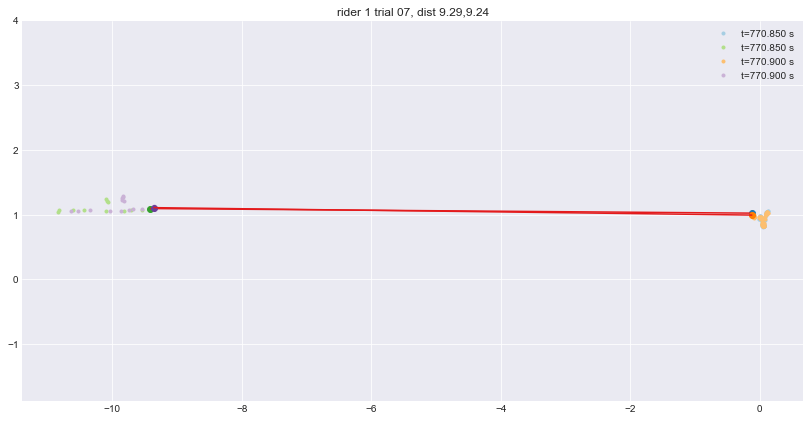

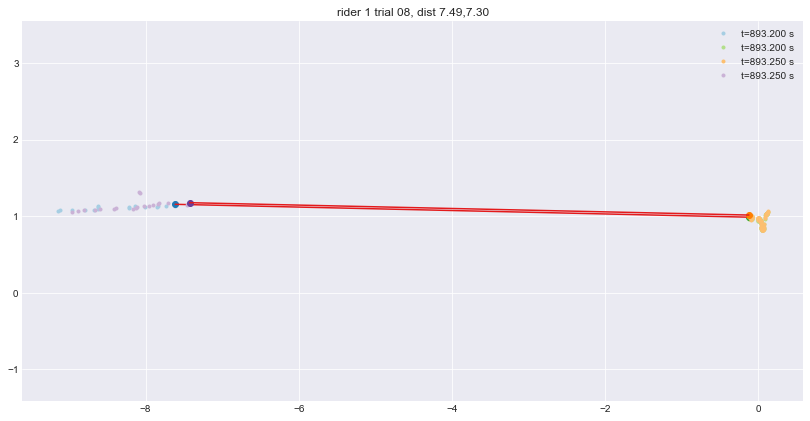

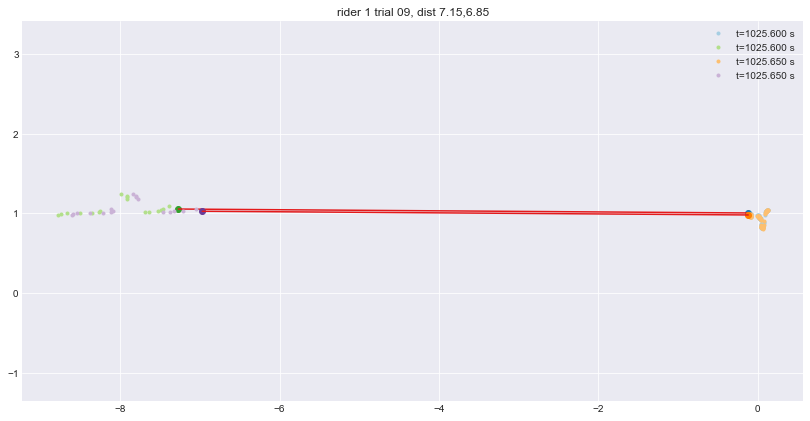

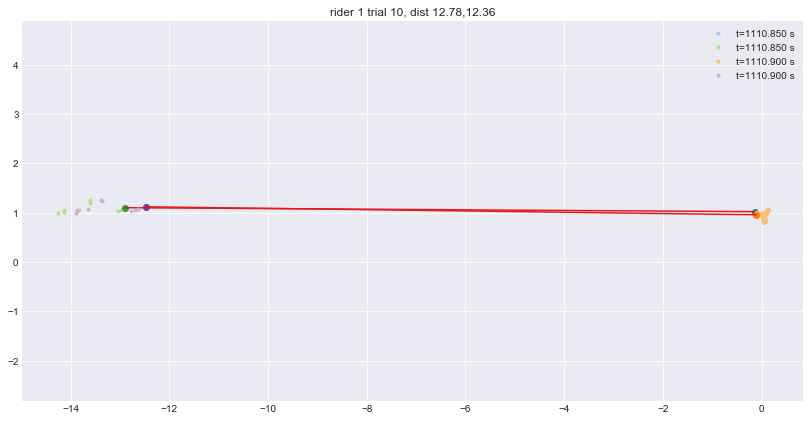

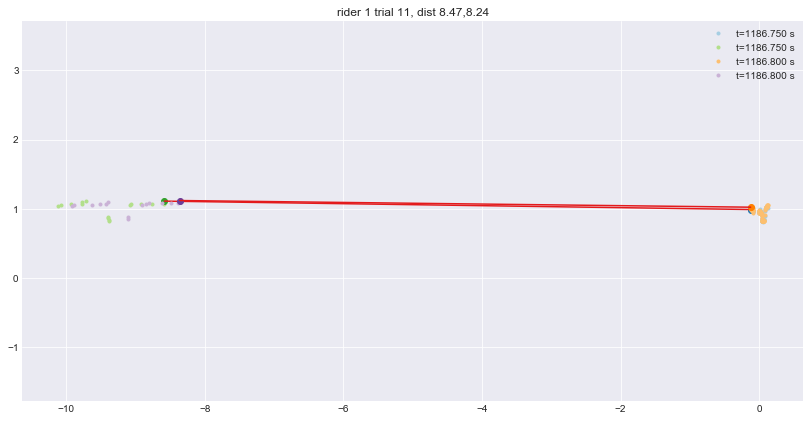

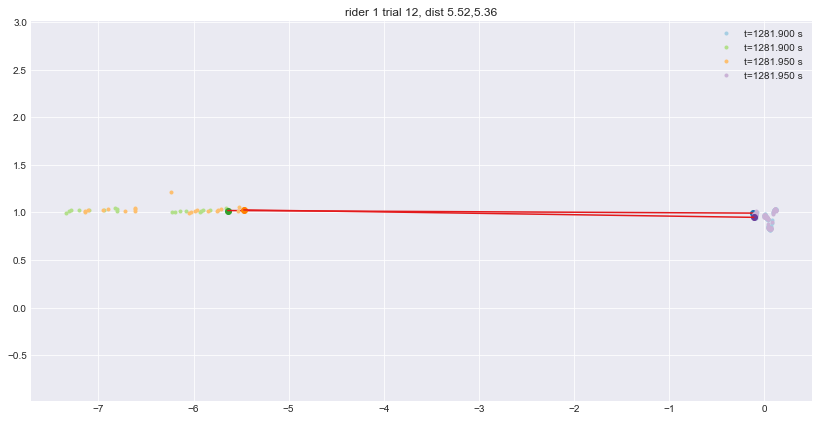

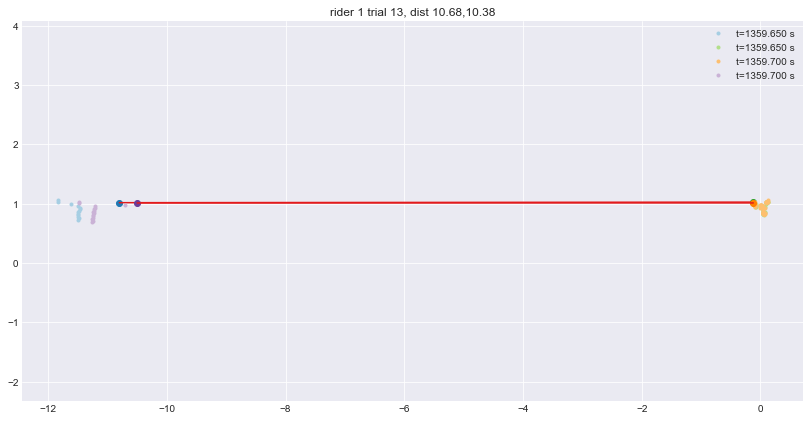

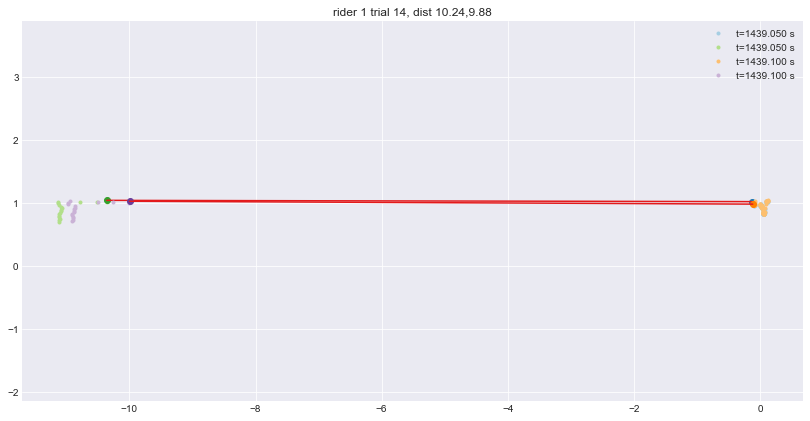

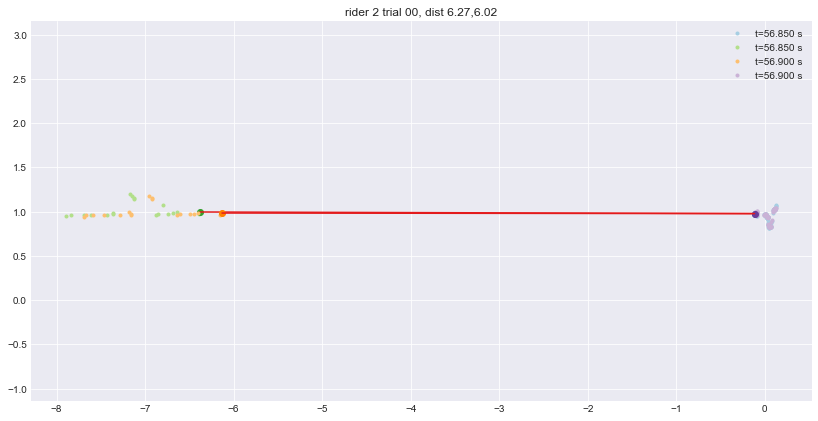

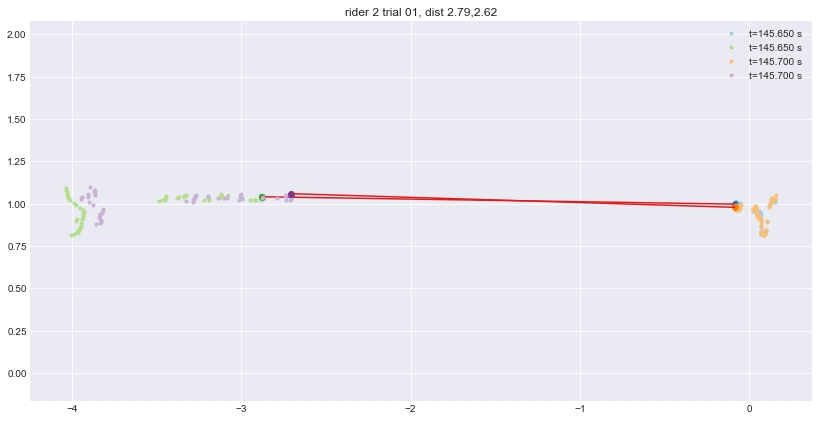

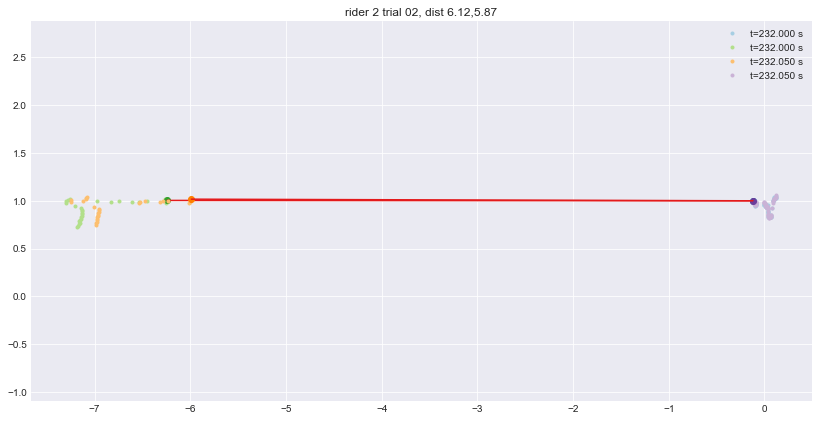

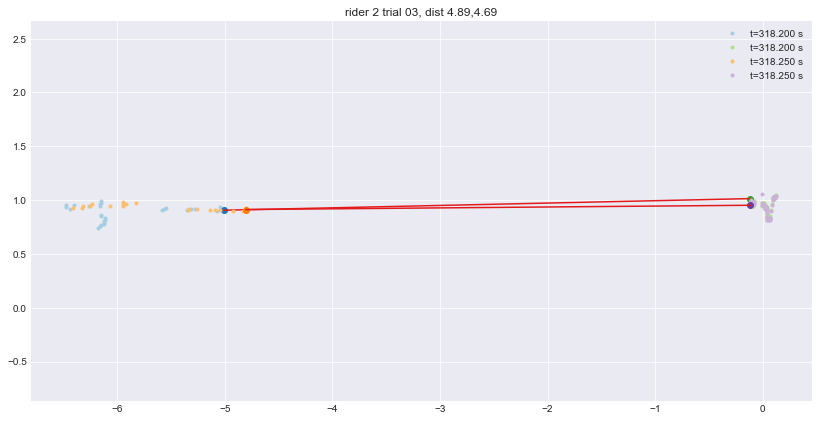

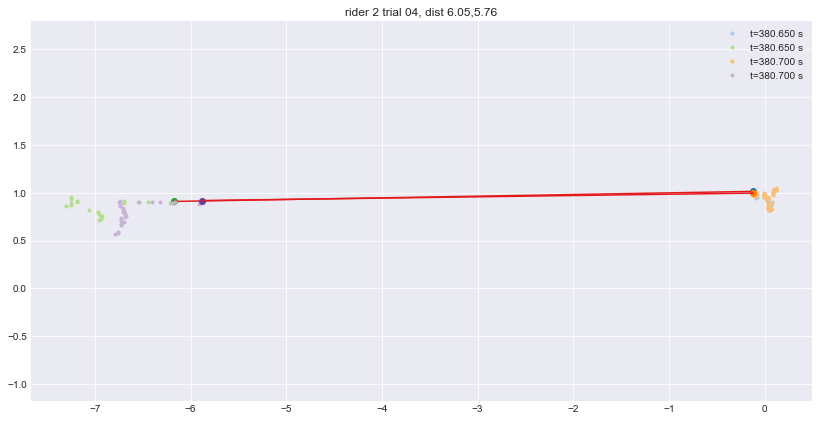

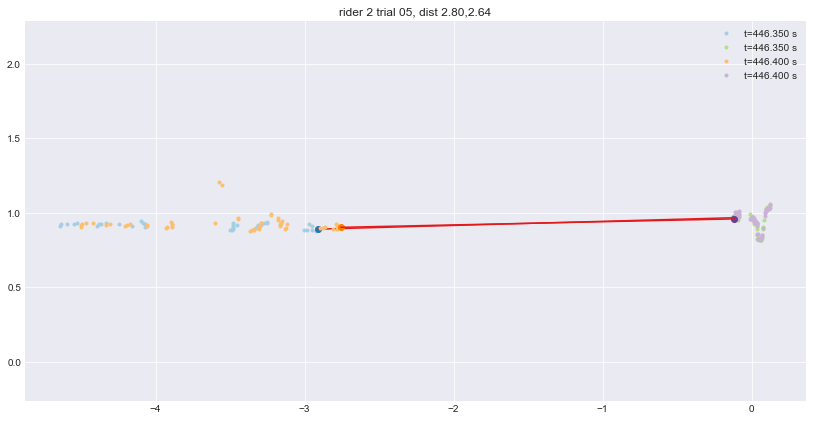

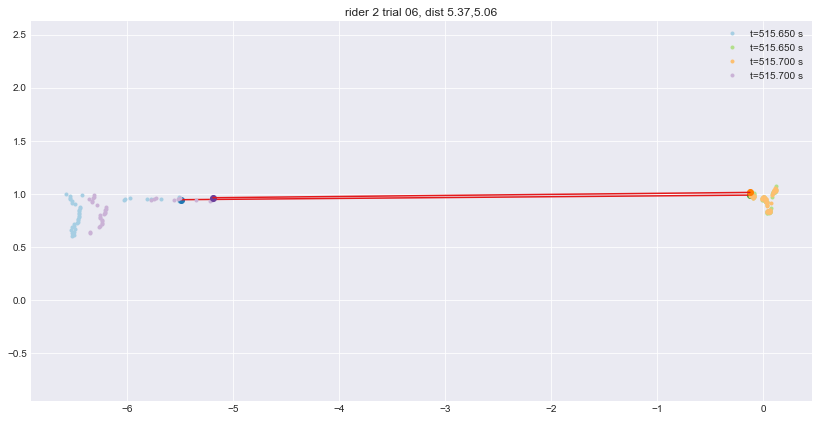

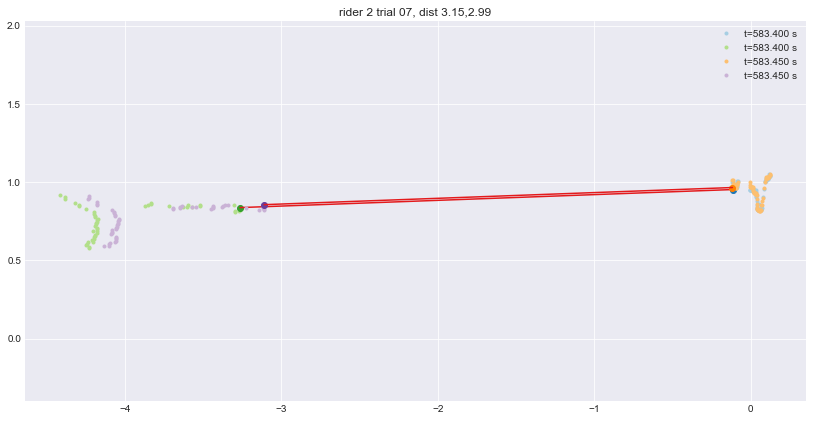

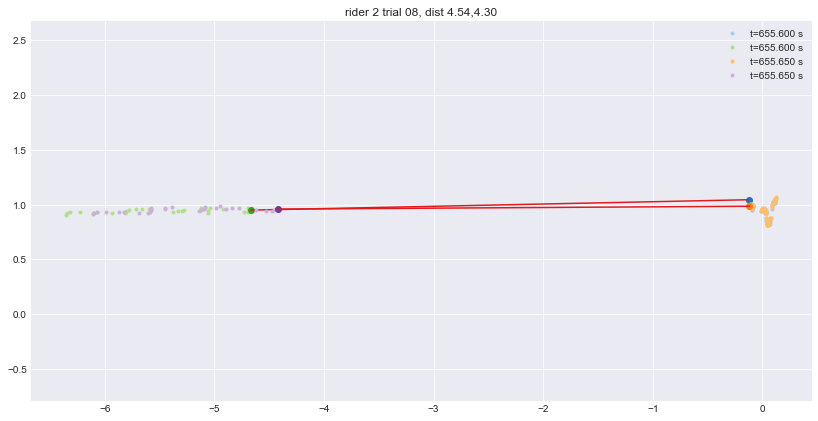

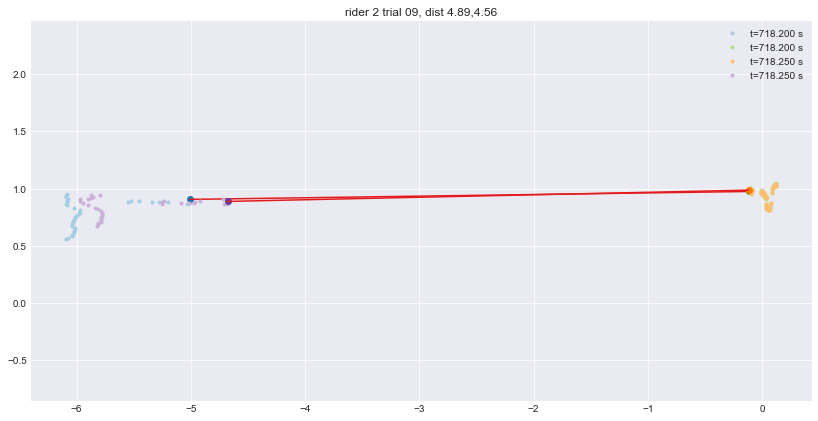

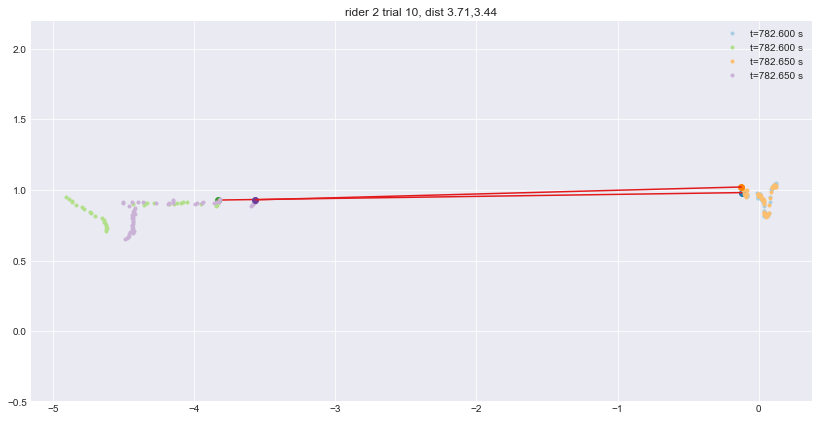

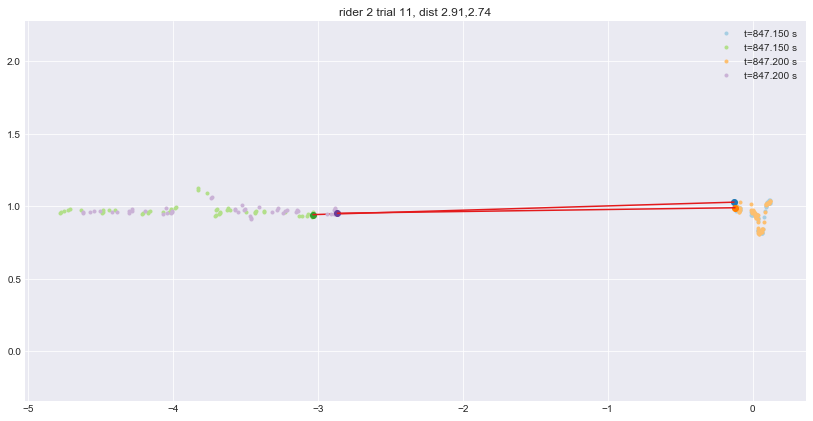

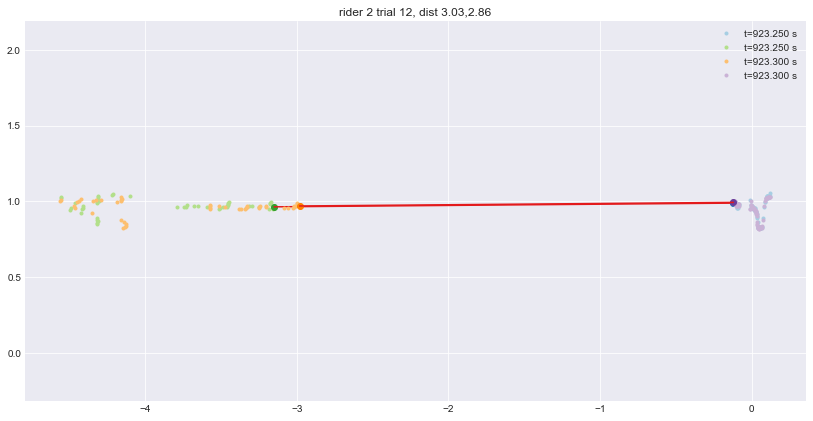

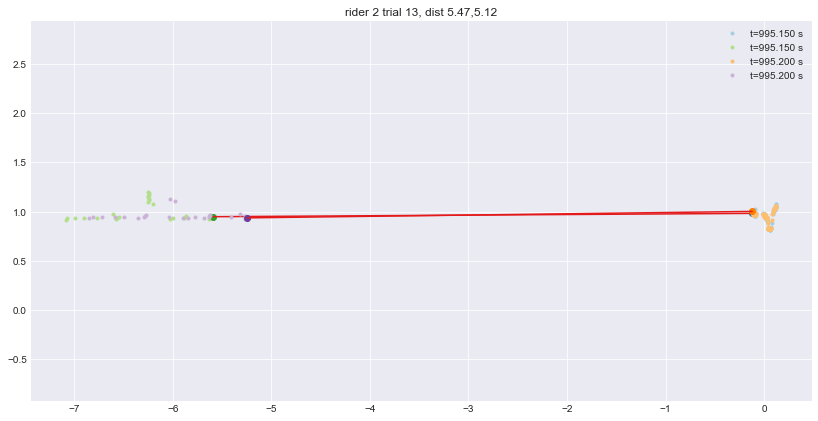

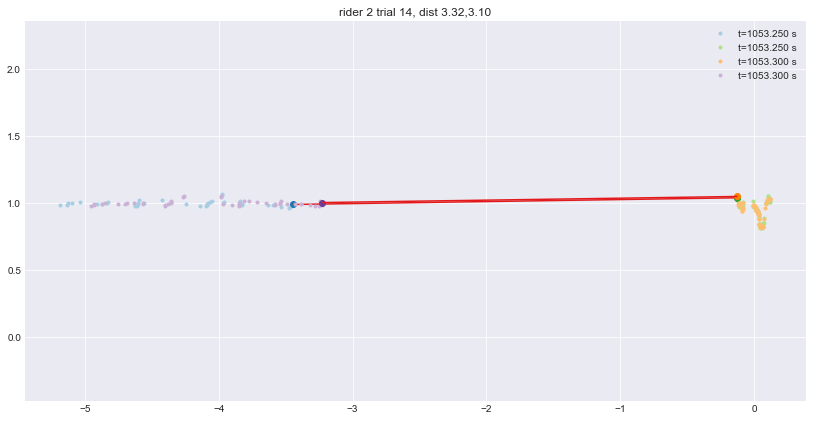

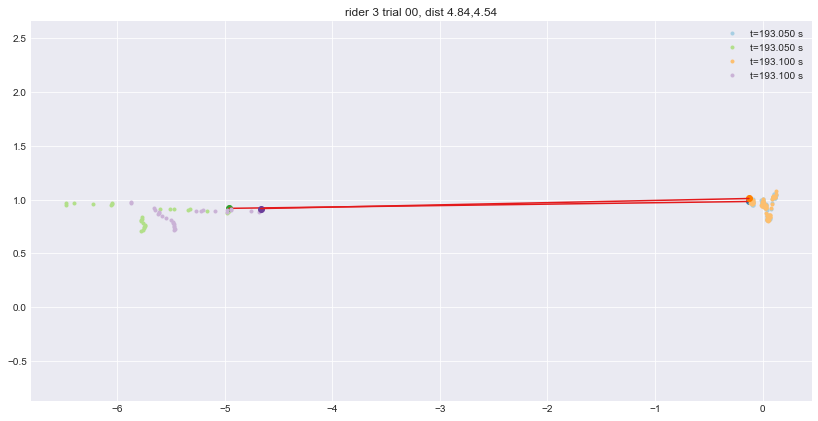

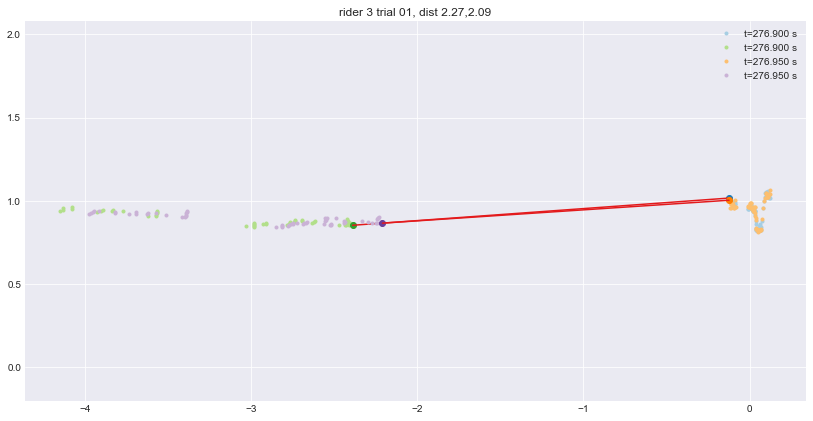

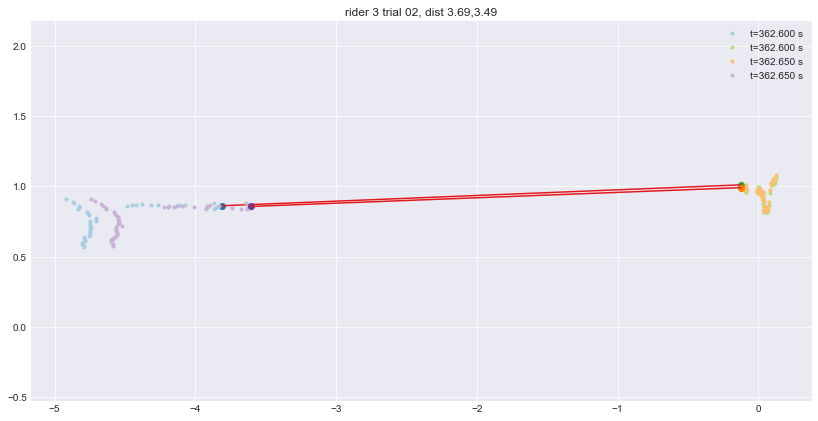

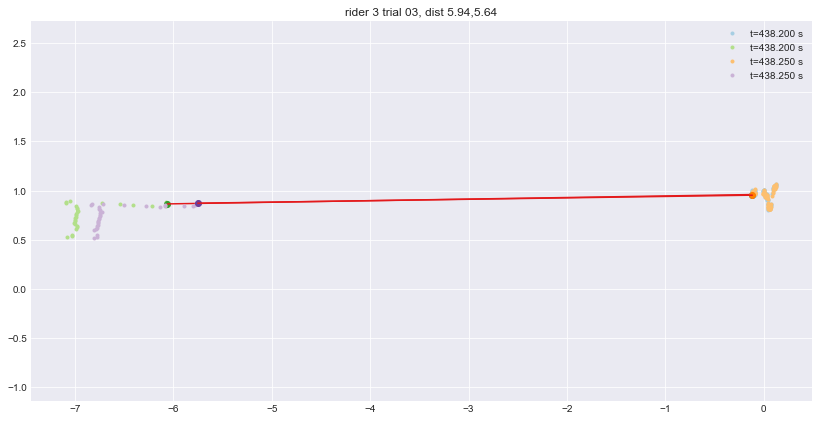

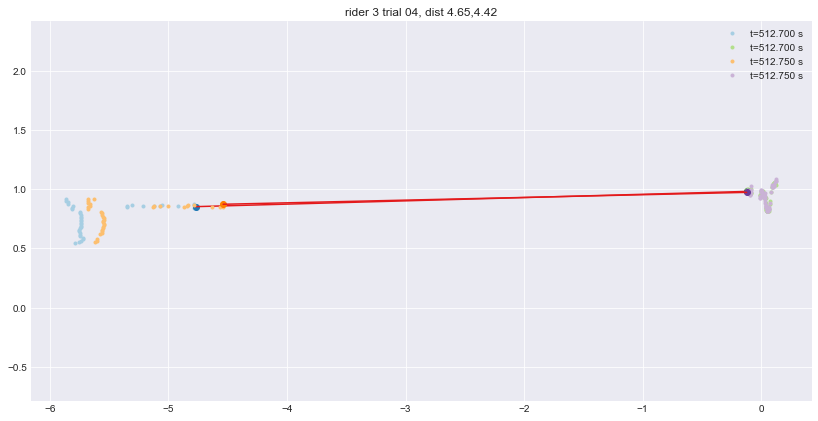

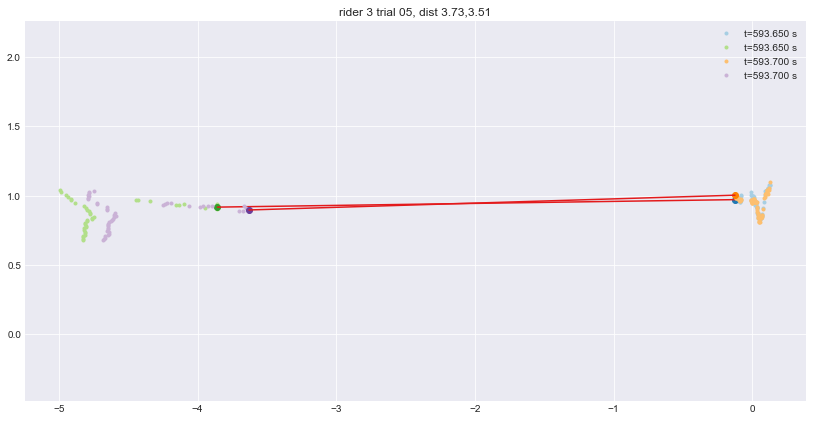

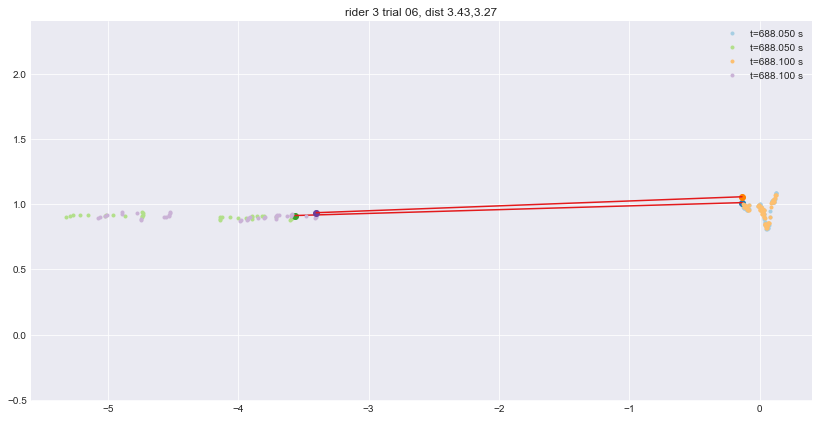

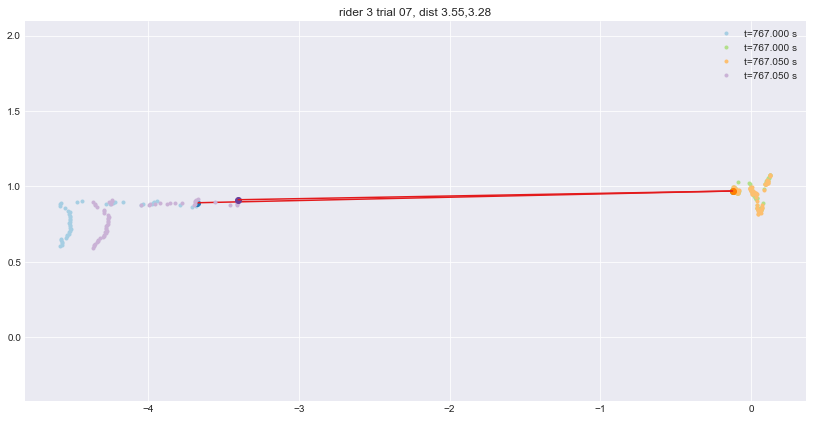

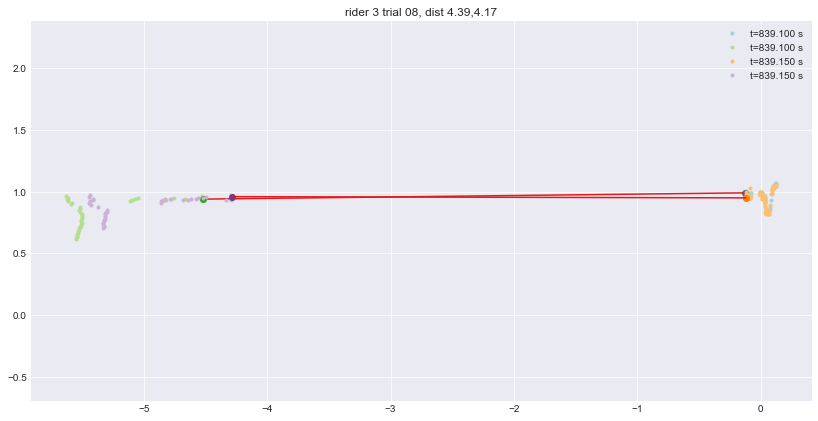

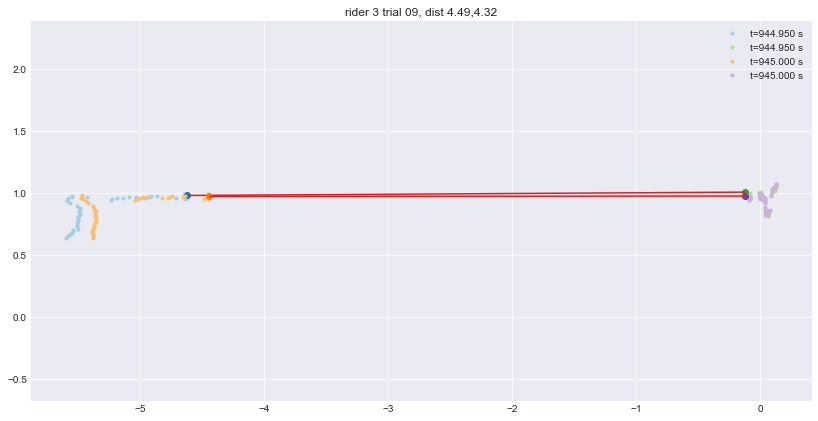

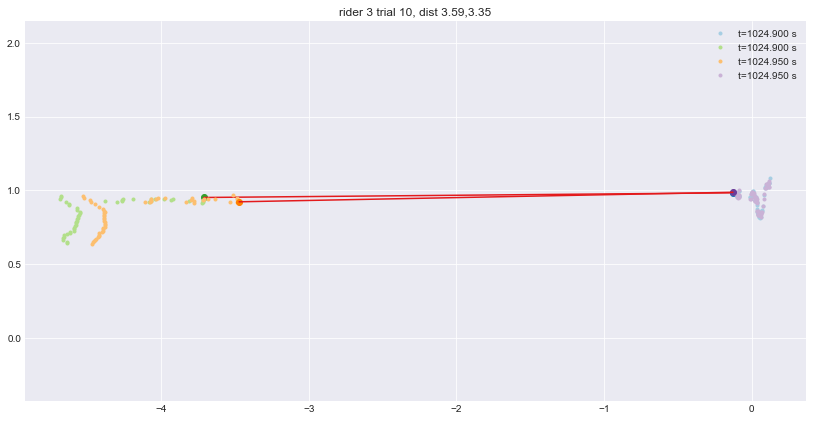

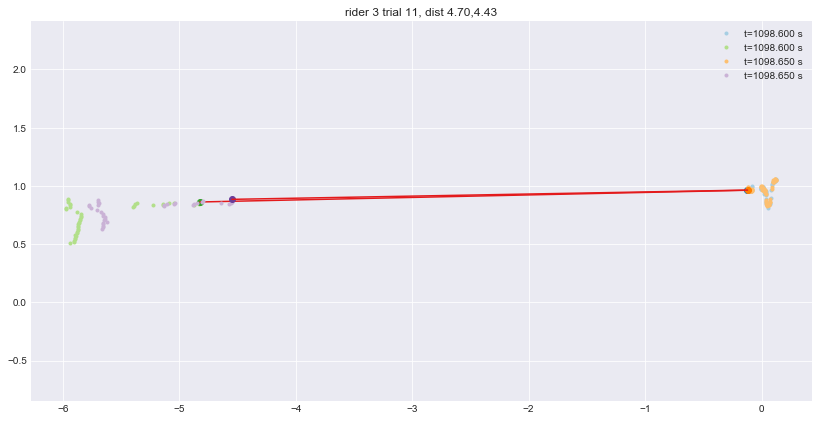

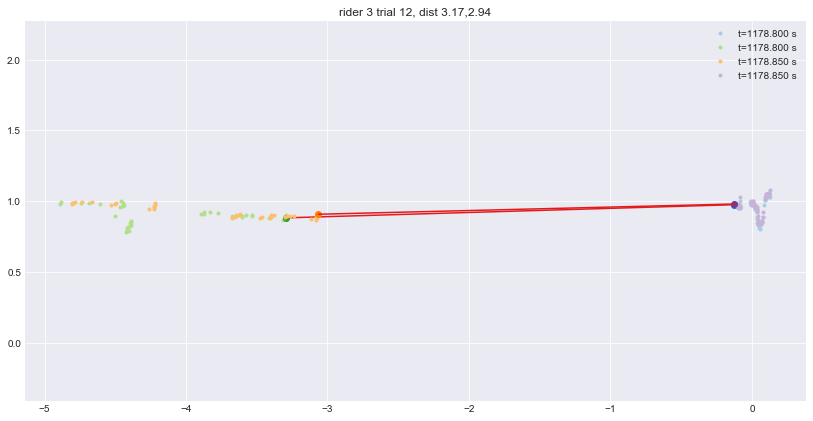

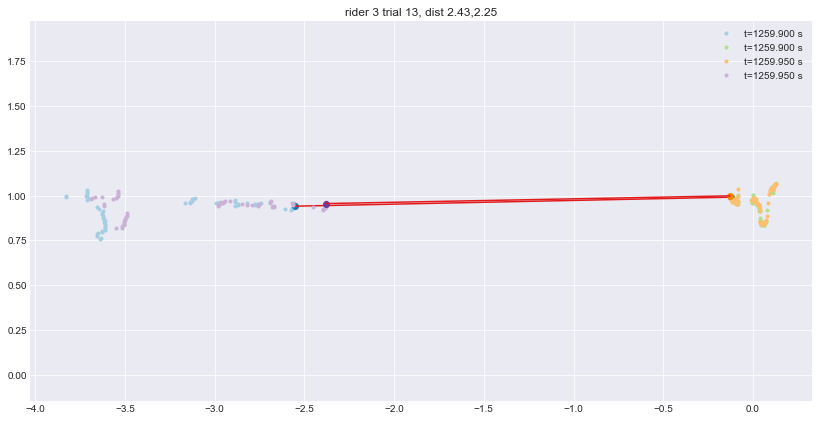

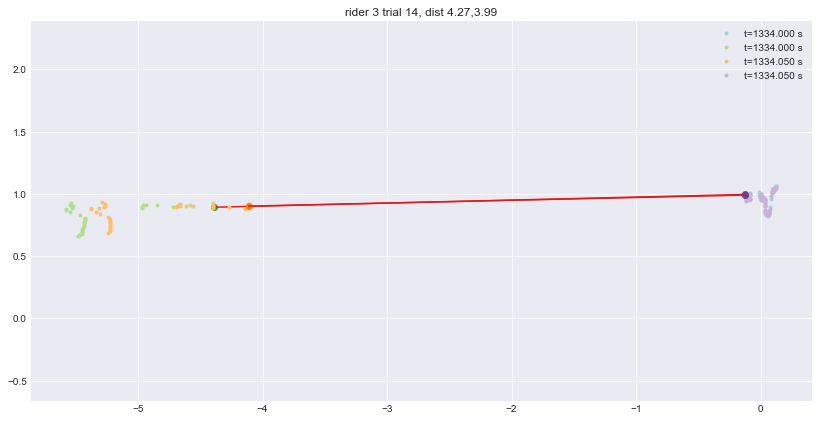

In [5]:
# rider, trial, speed, dist1, dist2, dist_interp, max_y
data = np.zeros((4*15, 7))

plt.close('all')
for rid, tid in itertools.product(range(4), range(15)):
    if (rid == 0) and (tid == 1):
        data[rid*15 + tid, :] = np.array([
            rid,
            tid,
            np.nan,  # speed
            np.nan,  # dist1
            np.nan,  # dist2
            np.nan,  # dist_interp
            np.nan]) # max_y
        continue
        
    record = records[rid]
    trial = record.trial[tid]
    
    # get steer event 
    _, (ev_time, _, _), ev = trial.steer_event_parameters()
    
    # determine max y-position
    indices = record.lidar.frame_index(
        lambda t: (t > ev_time[0]) & (t < ev_time[-1]))
    max_y = record.lidar[indices].cartesian(xlim=(-6, 2), ylim=(0.5, 3))[1].max()
    
    # get index before time 0
    index = record.lidar.frame_index(ev_time[0])
    # indices before and after event start
    index = np.insert(index, 0, index[0] - 1)

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    dist = []
    # get closest pair distance for 2 frames
    for i, c in zip(index, [0, 6]):
        frame = record.lidar[[i]]
        x, y = frame.cartesian(xlim=(-19, 1),
                                ylim=(0.5, 3))
        
        d, pair_a, pair_b, set_a, set_b = closest_pair(x, y)
        plot_closest_pair(ax, pair_a, pair_b, set_a, set_b, c)
        dist.append(d)
    
    ax.legend()
    ax.set_aspect('equal', 'datalim')
    ax.set_title('rider {} trial {:02d}, dist {}'.format(
        rid, tid, ','.join('{:0.02f}'.format(d) for d in dist)))
    
    dist_interp = np.interp(ev_time[0], record.lidar.time[index], dist)
    data[rid*15 + tid, :] = np.array([rid, tid, ev.speed, dist[0], dist[-1], dist_interp, max_y])
plt.show()

In [6]:
import pandas as pd
from antlia.plotdf import plotjoint
colors = sns.color_palette()

# remove rows with nan
index = np.where(np.any(np.isnan(data), axis=1))[0]
data = np.delete(data, index, axis=0)

# Average speed (v) in this dataframe is over the
# steer avoidance event (infl, min, infl, max, infl, min, infl)
# and not just the sinusoid fit region (infl, min, infl)
df = pd.DataFrame(data=data, columns=['rider', 'trial', 'v', 'd1', 'd2', 'di', 'max_y'])

df['t1'] = df.apply(lambda row: row.d1/row.v, axis=1)
df['t2'] = df.apply(lambda row: row.d2/row.v, axis=1)
df['ti'] = df.apply(lambda row: row.di/row.v, axis=1)
df

,rider,trial,v,d1,d2,di,max_y,t1,t2,ti
0,0.0,0.0,0.294541,3.261250,3.110582,3.177190,1.763553,11.072318,10.560783,10.786922
1,0.0,2.0,6.022226,10.043523,9.785744,9.838382,1.409885,1.667743,1.624938,1.633679
2,0.0,3.0,4.016655,2.931695,2.752570,2.897776,1.655686,0.729885,0.685289,0.721440
3,0.0,4.0,5.368322,5.347680,5.116617,5.320816,1.421042,0.996155,0.953113,0.991151
4,0.0,5.0,5.994924,4.713290,4.420386,4.553382,1.414660,0.786214,0.737355,0.759540
5,0.0,6.0,4.567633,4.540185,4.293193,4.323005,1.638882,0.993991,0.939916,0.946443
6,0.0,7.0,5.189857,4.540644,4.274900,4.401065,1.655332,0.874907,0.823703,0.848013
7,0.0,8.0,6.206539,6.002774,5.673217,5.985420,1.598131,0.967169,0.914071,0.964373
8,0.0,9.0,4.198477,5.416400,5.200622,5.335181,1.704569,1.290087,1.238693,1.270742
9,0.0,10.0,5.559790,4.131030,3.893611,4.064961,1.546172,0.743019,0.700316,0.731136


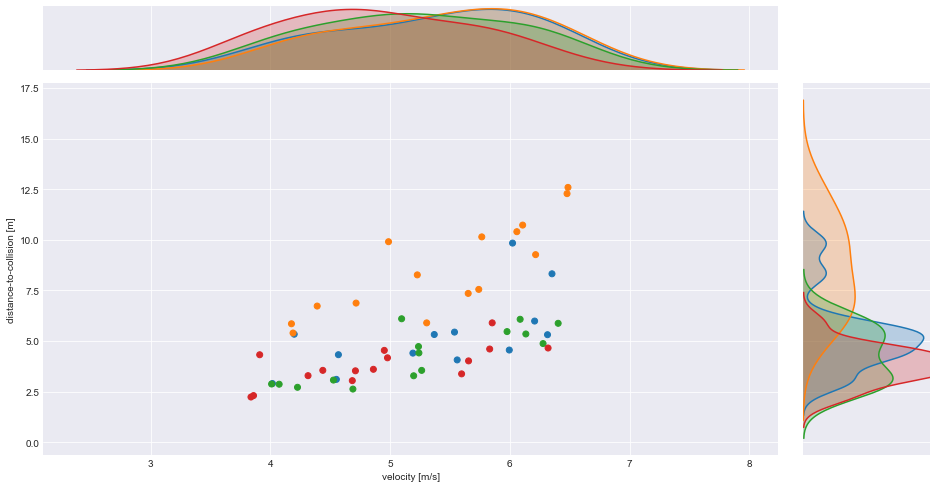

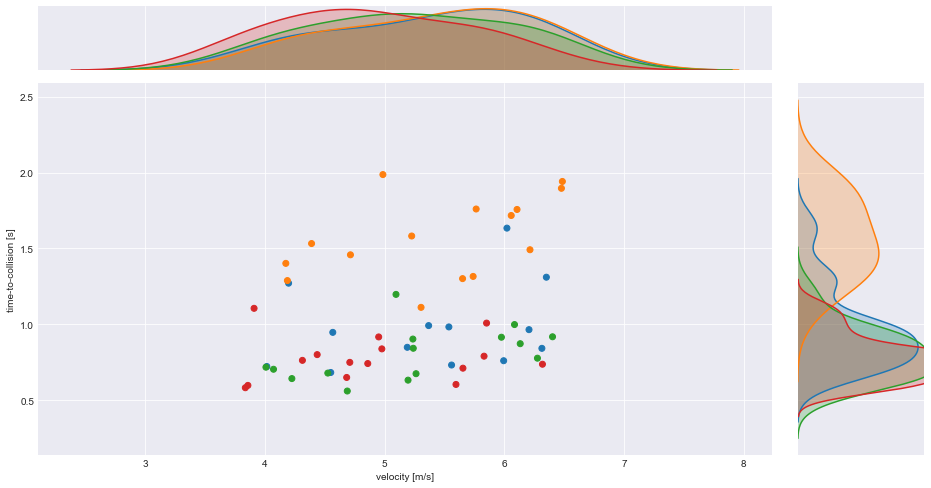

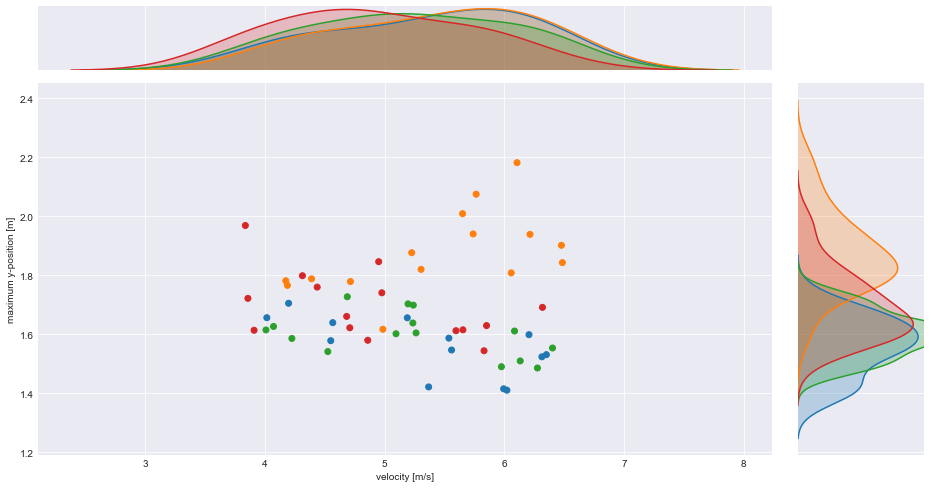

In [7]:
# exclude trials without working velocity sensor
plt.close('all')
#g = plotjoint('v', 'd1', df[df.v > 1], ('rider', colors))
#g.fig.set_size_inches(DEFAULT_FIGSIZE)
#
#g = plotjoint('v', 'd2', df[df.v > 1], ('rider', colors))
#g.fig.set_size_inches(DEFAULT_FIGSIZE)
#
g = plotjoint('v', 'di', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'distance-to-collision [m]')
#
#g = plotjoint('v', 't1', df[df.v > 1], ('rider', colors))
#g.fig.set_size_inches(DEFAULT_FIGSIZE)
#
#g = plotjoint('v', 't2', df[df.v > 1], ('rider', colors))
#g.fig.set_size_inches(DEFAULT_FIGSIZE)

g = plotjoint('v', 'ti', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'time-to-collision [s]')

g = plotjoint('v', 'max_y', df[df.v > 1], ('rider', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'maximum y-position [m]')
plt.show()

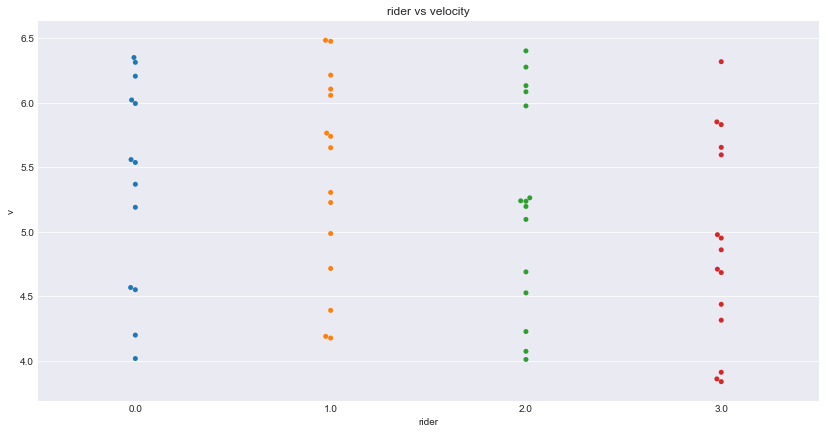

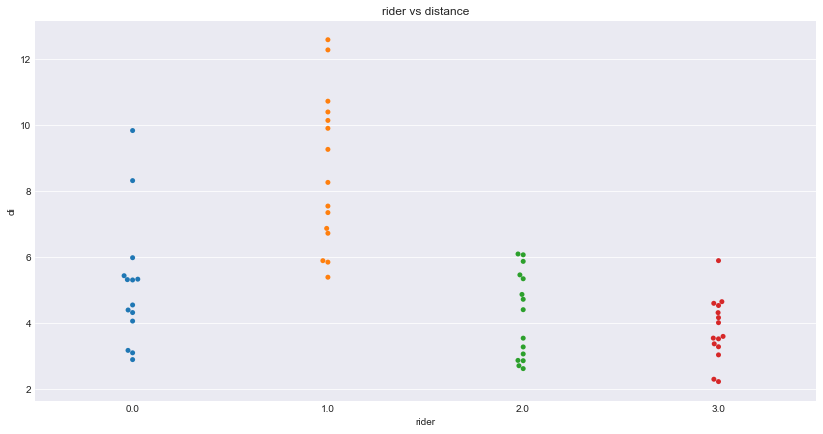

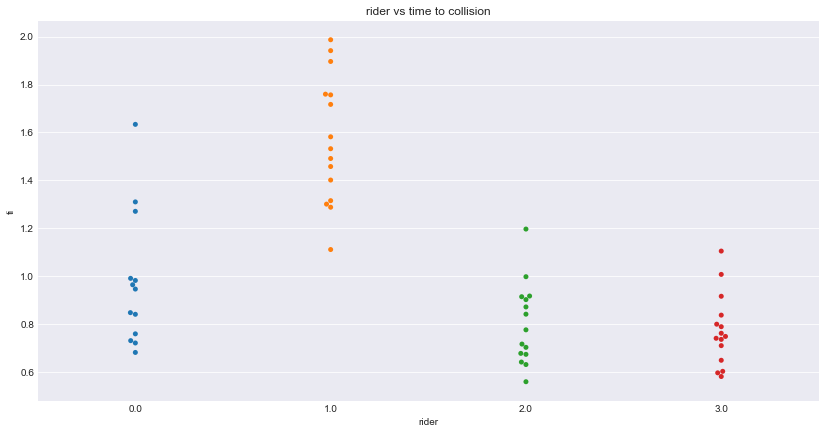

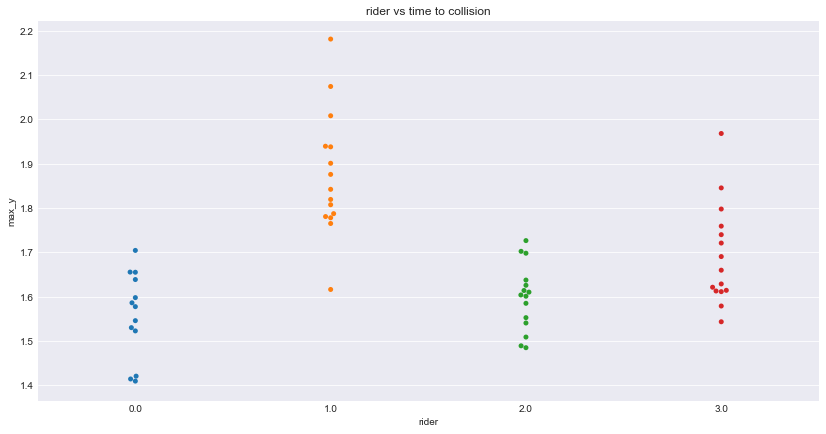

In [8]:
%matplotlib inline
plt.close('all')
# exclude trial without working velocity sensor
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='v', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs velocity')

#fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
#sns.swarmplot(x='rider', y='d1', data=df, ax=ax)
#ax.set_title('rider vs distance')

#fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
#sns.swarmplot(x='rider', y='d2', data=df, ax=ax)
#ax.set_title('rider vs distance')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='di', data=df, ax=ax)
ax.set_title('rider vs distance')

#fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
#sns.swarmplot(x='rider', y='t1', data=df[df.v > 1], ax=ax)
#ax.set_title('rider vs time to collision')

#fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
#sns.swarmplot(x='rider', y='t2', data=df[df.v > 1], ax=ax)
#ax.set_title('rider vs time to collision')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='ti', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs time to collision')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='max_y', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs time to collision')
plt.show()